
# Blind source separation using FastICA

An example of estimating sources from noisy data.

`ICA` is used to estimate sources given noisy measurements.
Imagine 3 instruments playing simultaneously and 3 microphones
recording the mixed signals. ICA is used to recover the sources
ie. what is played by each instrument. Importantly, PCA fails
at recovering our `instruments` since the related signals reflect
non-Gaussian processes.


## ICA applied to UBF underwater signals 



In [2]:
import os
import numpy as np
import pandas as pd
import scipy.signal as sp
import matplotlib.pyplot as plt 
import scipy.io.wavfile as wavfile

from skimage.metrics import structural_similarity as ssim

### Synthetic signals 
Feasability test on synthetic data 

In [3]:
# FFT params
nperseg = 512
noverlap = 256
fs = 100

# Noise 
np.random.seed(0)
snr = 10
# sigma_noise = 0.1 # 0.1 Pa


#### Load data 

In [4]:
# Load data
root = r"C:\Users\baptiste.menetrier\Desktop\devPy\phd\data\signaux_ica_jl"
# vars = ["p", "x", "y", "z"]
fs = 100    # 100 Hz RHUM RUM 
vars = ["ondeT", "navire", "Zcall"]

data = {}
spectro = {}
noise = {}
fpaths = {}
for v in vars:
    fpaths[v] = os.path.join(root, f"{v}.txt")
    s = pd.read_csv(fpaths[v])

    # roll to have two signals 
    if v == "ondeT":
        idx_t_s0 = np.argmax(s.values)
        t_s1 = 250
        shift_s1 = int(t_s1 * fs) - idx_t_s0   
        s1 = np.roll(s, shift_s1, axis=0)

        t_s2 =  1400
        shift_s2 = int(t_s2 * fs) - idx_t_s0
        s2 = np.roll(s, shift_s2, axis=0)
        s = s1 + s2

    # Normalize data 
    s = s / np.max(s)

    # Derive sigma noise 
    P_sig = np.mean(s**2)
    sigma_noise = np.sqrt(P_sig / (10**(snr/10)))
    noise[v] = np.random.normal(0, sigma_noise, len(s))
    
    # Add noise
    s = np.array(s).flatten()
    s += noise[v]
    data[v] = s
    
    # Derive spectro 
    # s_spec = data[v]
    freq, tt, Sxx = sp.spectrogram(data[v], fs=fs, nperseg=nperseg, noverlap=noverlap)
    Sxx[Sxx == 0] = np.min(Sxx[Sxx != 0])
    spectro[v] = 10*np.log10(Sxx)

nt = len(data[v])
time = np.arange(0, nt*1/fs, 1/fs)


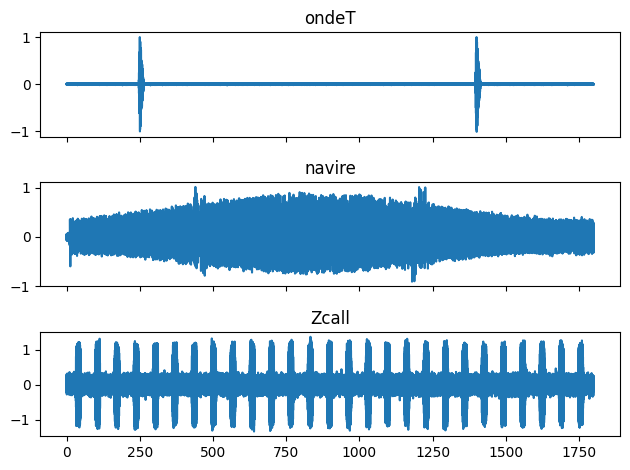

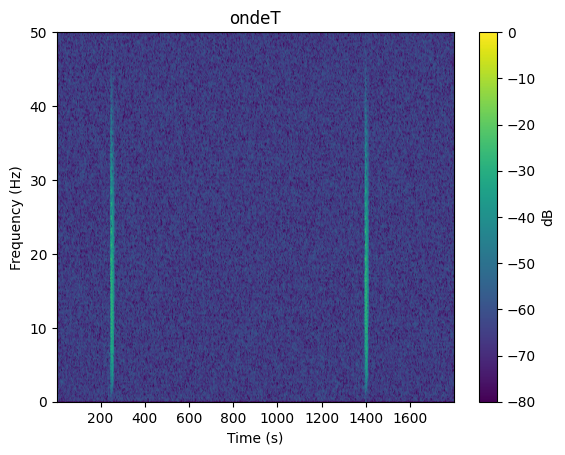

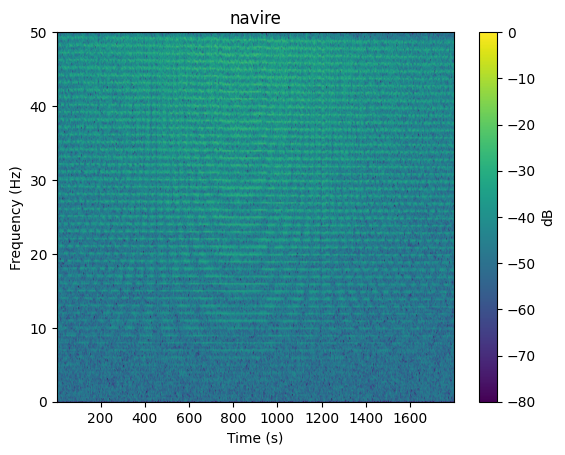

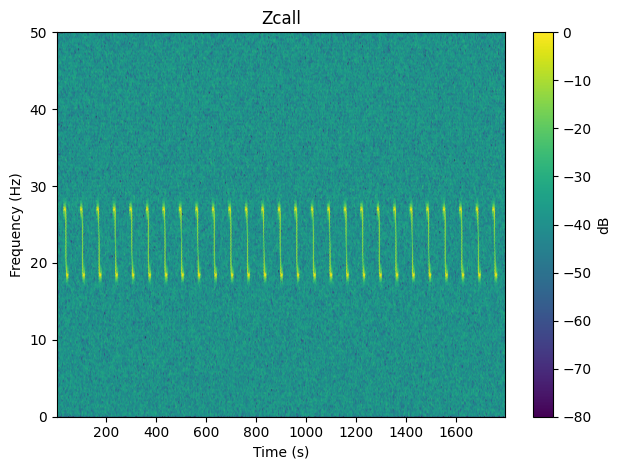

In [5]:
# Plot data
f, axs = plt.subplots(len(data.keys()), 1, sharex=True)
for iv, v in enumerate(vars):
    axs[iv].plot(time, data[v])
    axs[iv].set_title(v)
plt.tight_layout()


# f, axs = plt.subplots(1, len(data.keys()), sharex=True)
for iv, v in enumerate(vars):
    plt.figure()
    plt.title(v)
    im = plt.pcolormesh(tt, freq, spectro[v], shading="gouraud", vmin=-80, vmax=0)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(im, label="dB")

plt.tight_layout()
plt.show()

#### Mix signals 

In [6]:
v_tuple = tuple([data[v] for v in data.keys()])
S = np.c_[v_tuple]

# Standardize data
S /= S.std(axis=0)  

# Mix data
sum_mat = np.ones((S.shape[1], S.shape[1]))
noise_sum = 0.01 * np.random.normal(size=sum_mat.shape)
A = sum_mat + noise_sum
print(A)
# A = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])  # Mixing matrix
X = np.dot(S, A.T)  # Observations

[[1.00656011 1.01555735 1.00468129]
 [0.9839028  0.98537019 0.99581595]
 [1.00046299 0.99471175 1.02370009]]


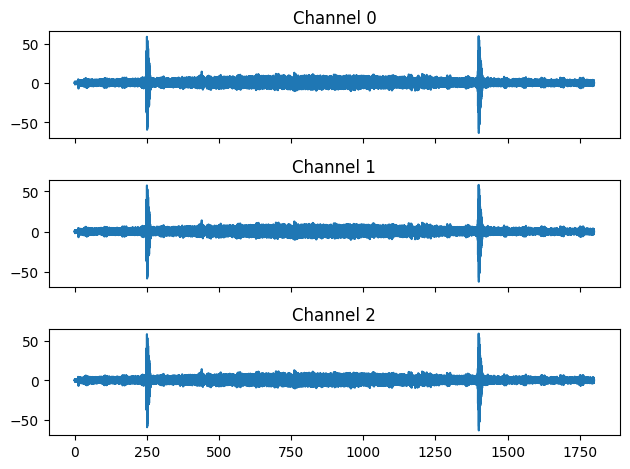

In [7]:
# Plot mixed data
f, axs = plt.subplots(len(data.keys()), 1, sharex=True)
for iv, v in enumerate(vars):
    axs[iv].plot(time, X[:, iv])
    axs[iv].set_title(f"Channel {iv}")

plt.tight_layout()
plt.show()

#### Fit ICA 

In [8]:
from utils import apply_ica
from sklearn.decomposition import PCA

X, S_, A_ = apply_ica(data, n_components=3)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

ICA model applies : True
Components : [[-2.37097320e-05 -2.88668633e-08 -6.69665200e-03]
 [ 1.40357940e-01 -6.27043080e-06 -6.75492524e-08]
 [ 1.30628663e-04 -2.52883567e-02 -1.49151563e-07]]
Mixing : [[-7.18270597e-05  7.12464309e+00 -1.76660666e-03]
 [ 8.80372520e-04  3.68029594e-02 -3.95438993e+01]
 [-1.49328351e+02 -2.52252082e-02  1.76714290e-04]]
Mean : [ 2.36283943e-05 -3.20946383e-05  5.55786709e-04]


In [9]:
from sklearn.decomposition import PCA, FastICA

X = np.c_[tuple([data[k] for k in data.keys()])]

# Compute ICA
ica = FastICA(n_components=3, whiten="arbitrary-variance")
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
# assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)
print(np.allclose(X, np.dot(S_, A_.T) + ica.mean_))
print(ica.components_)
print(ica.mixing_)
print(ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

True
[[-1.40357896e-01  1.47654477e-05  6.18296068e-06]
 [ 1.51884134e-04  2.94974181e-08  6.69664914e-03]
 [ 8.34789667e-05 -2.52883532e-02 -1.45391231e-07]]
[[-7.12463906e+00  6.57802991e-03 -4.15995027e-03]
 [-2.35199579e-02 -8.36823697e-04 -3.95439094e+01]
 [ 1.61591313e-01  1.49328265e+02  2.68533357e-04]]
[ 2.36283943e-05 -3.20946383e-05  5.55786709e-04]


## Plot results



<Figure size 640x480 with 0 Axes>

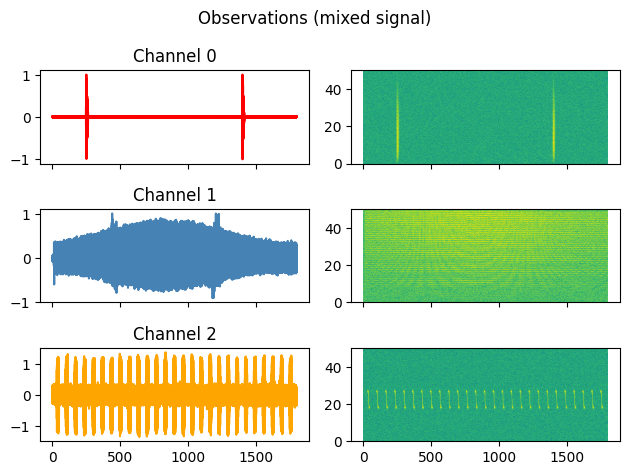

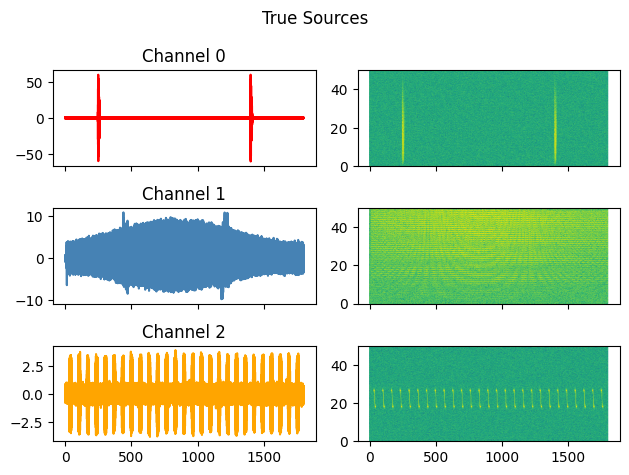

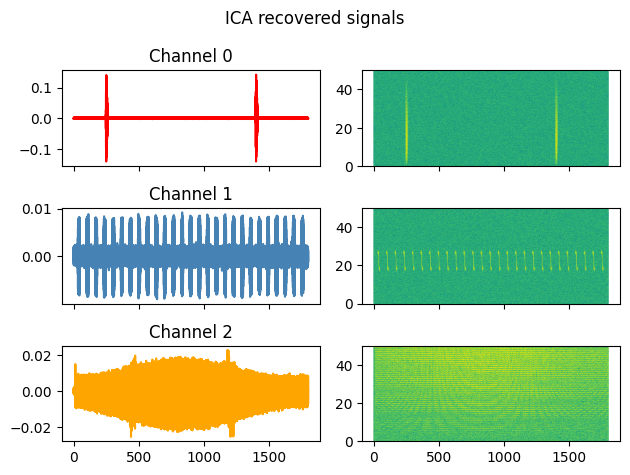

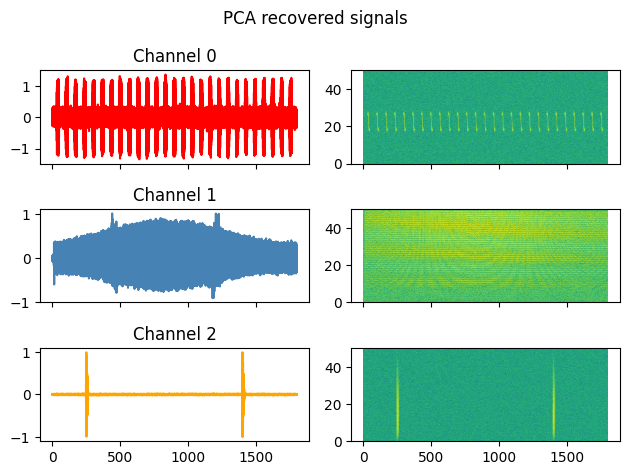

In [10]:
plt.figure()

models = [X, S, S_, H]
names = [
    "Observations (mixed signal)",
    "True Sources",
    "ICA recovered signals",
    "PCA recovered signals",
]
colors = ["red", "steelblue", "orange"]


for ii, (model, name) in enumerate(zip(models, names), 1):
    f, axs = plt.subplots(len(data.keys()), 2, sharex=True)
    plt.suptitle(name)
    isig = 0
    for sig, color in zip(model.T, colors):
        axs[isig, 0].plot(time, sig, color=color)
        axs[isig, 0].set_title(f"Channel {isig}")

        freq, tt, Sxx = sp.spectrogram(sig, fs=fs, nperseg=nperseg, noverlap=noverlap)
        axs[isig, 1].pcolormesh(tt, freq, 10 * np.log10(Sxx), shading="gouraud")
        isig += 1

    plt.tight_layout()
    plt.show()

In [11]:
# Save ica results
ica_data = {}
ica_spectro = {}
# pay attention to the order of the variables (different from the original data)
ica_vars = [
    "ondeT",
    "Zcall",
    "navire",
]
for iv, v in enumerate(ica_vars):
    ica_data[v] = S_[:, iv] 
    # Normalize ica output 
    ica_data[v] = ica_data[v] / np.max(ica_data[v])
    freq, tt, Sxx = sp.spectrogram(
        ica_data[v], fs=fs, nperseg=nperseg, noverlap=noverlap
    )
    ica_spectro[v] = 10*np.log10(Sxx)

#### Quantify separation performance using structural similarity index

In [12]:
# Quantify performance byusing
perf = {"intercorr": {}, "ssim": {}}
sig_names = ["navire", "ondeT", "Zcall"]

# Intercorrelation
print("Inter-correlation :\n")
for isn, sn in enumerate(sig_names):
    a = ica_data[sn].flatten()
    b =  np.array(data[sn]).flatten()
    perf["intercorr"][sn] = np.sum(a * b) / np.sqrt(np.sum(a**2) * np.sum(b ** 2))
    print(f"\t{sn} : {np.round(perf['intercorr'][sn], 3)}")

# SSIM
print("SSIM :\n")
for isn, sn in enumerate(sig_names):
    L = ica_spectro[sn].max() - ica_spectro[sn].max()
    perf["ssim"][sn] = ssim(ica_spectro[sn], spectro[sn], data_range=L)
    print(f"\t{sn} : {np.round(perf['ssim'][sn], 3)}")

Inter-correlation :

	navire : -1.0
	ondeT : -1.0
	Zcall : 1.0
SSIM :

	navire : 1.0
	ondeT : 1.0
	Zcall : 0.998


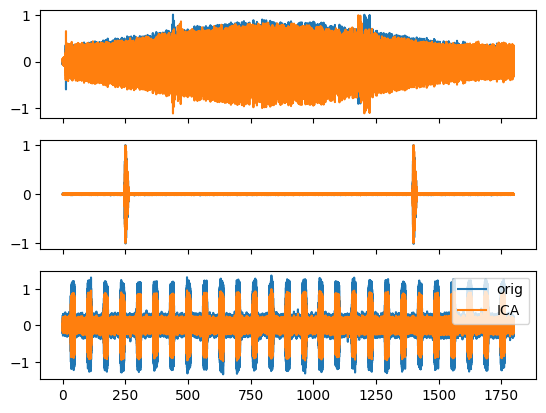

In [13]:
f, axs = plt.subplots(len(data.keys()), 1, sharex=True)
for isn, sn in enumerate(sig_names):
    axs[isn].plot(time, data[sn], label="orig")
    axs[isn].plot(time, ica_data[sn], label="ICA")
plt.legend()
plt.show()

In [14]:
# Test with real data

# Load data
root_data = r"C:\Users\baptiste.menetrier\Desktop\devPy\phd\data\wav\RHUMRUM"
signal = {}
spectro = {}
channels = ["BDH", "BHZ", "BH1", "BH2"]
for chnl in channels:
    fname = f"signal_{chnl}_RR44_2013-05-3.wav"
    fs, signal[chnl] = wavfile.read(os.path.join(root_data, fname))

    # Normalize data 
    signal[chnl] = signal[chnl] / np.max(signal[chnl])
    
    f, tt, Sxx = sp.spectrogram(signal[chnl], fs=fs, nperseg=nperseg, noverlap=noverlap)
    spectro[chnl] = 10*np.log10(Sxx)

time = np.arange(0, len(signal[chnl])*1/fs, 1/fs)

Text(0.5, 0, 'Time [s]')

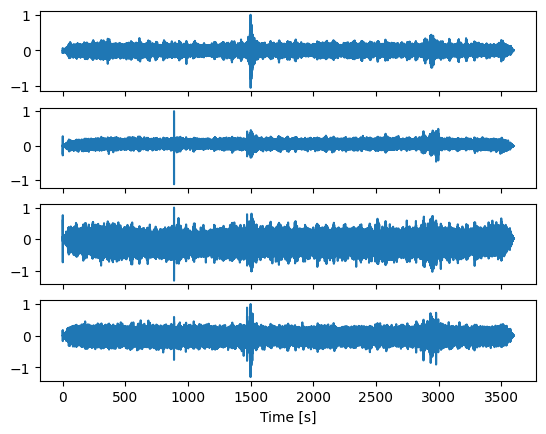

In [15]:
import scipy.signal as sp 

fig, axs = plt.subplots(4, 1, sharex=True)
for ic, chnl in enumerate(channels):
    axs[ic].plot(time, signal[chnl], label=chnl)

plt.xlabel("Time [s]")


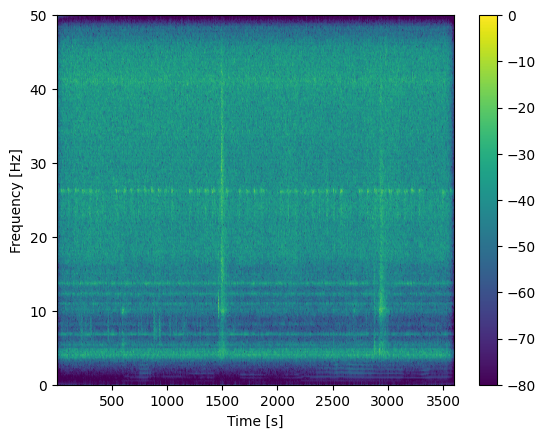

In [16]:
plt.figure()
im = plt.pcolormesh(tt, f, spectro[chnl], vmin=-80, vmax=0, shading="gouraud")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(im)

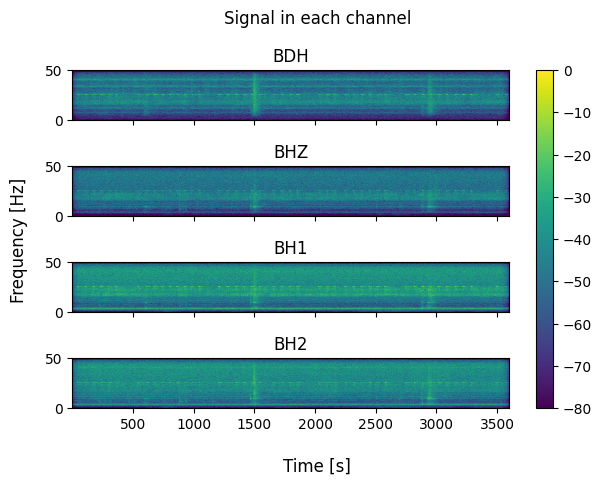

In [17]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
for ic, chnl in enumerate(channels):
    im = axs[ic].pcolormesh(tt, f, spectro[chnl], vmin=-80, vmax=0, shading="gouraud")
    axs[ic].set_title(chnl)
fig.supxlabel("Time [s]")
fig.supylabel("Frequency [Hz]")
fig.suptitle("Signal in each channel")
plt.tight_layout()
fig.colorbar(im, ax=axs.ravel().tolist())

#### Intensity 

In [18]:
used_channels = ["BHZ", "BH1", "BH2"]
n_used_ch = len(used_channels)

intensity = {}
intensity_spectro = {}
for chnl in used_channels:
    intensity[chnl] = signal[chnl] * signal["BDH"]

    f, tt, Sxx = sp.spectrogram(intensity[chnl], fs=fs, nperseg=nperseg, noverlap=noverlap)
    intensity_spectro[chnl] = 10*np.log10(Sxx)

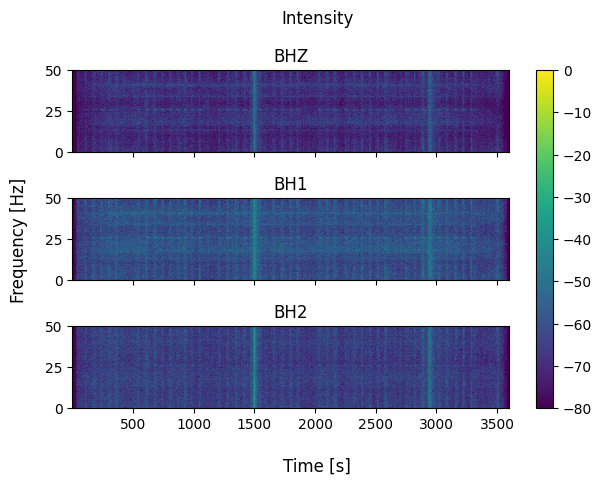

In [20]:
fig, axs = plt.subplots(n_used_ch, 1, sharex=True, sharey=True)
for ic, chnl in enumerate(used_channels):
    im = axs[ic].pcolormesh(tt, f, intensity_spectro[chnl], vmin=-80, vmax=0, shading="gouraud")
    axs[ic].set_title(chnl)
fig.supxlabel("Time [s]")
fig.supylabel("Frequency [Hz]")
fig.suptitle("Intensity")
plt.tight_layout()
fig.colorbar(im, ax=axs.ravel().tolist())

In [21]:
# X = np.c_[tuple([signal[chnl] for chnl in used_channels])]
X = np.c_[tuple([intensity[chnl] for chnl in intensity.keys()])]

# Compute ICA
ica = FastICA(n_components=3, whiten="arbitrary-variance")
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)
# print(np.allclose(X, np.dot(S_, A_.T) + ica.mean_))
print(ica.components_)
print(ica.mixing_)
print(ica.mean_)

[[ 0.03174189 -0.07918477 -0.09702838]
 [ 0.19346929 -0.04144332  0.09187003]
 [ 0.24364136  0.07127024 -0.06501303]]
[[ 0.7398235   2.31615173  2.1688123 ]
 [-6.7125888  -4.14269049  4.16412711]
 [-4.58609937  4.13855255 -2.68883477]]
[0.00015233 0.00079587 0.0006529 ]


### Results 

<Figure size 640x480 with 0 Axes>

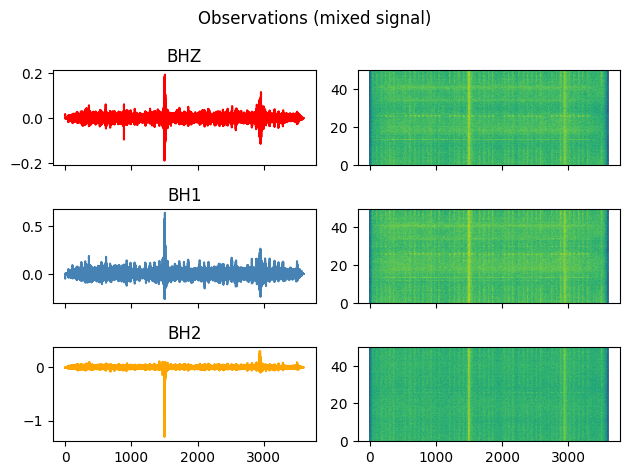

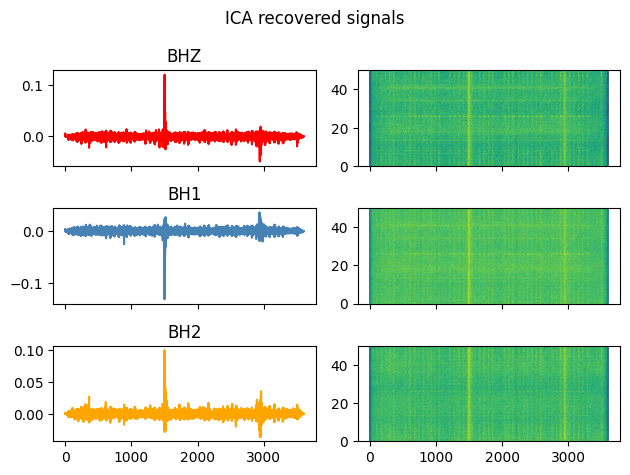

In [24]:
plt.figure()

models = [X, S_]
names = [
    "Observations (mixed signal)",
    "ICA recovered signals",
]
colors = ["red", "steelblue", "orange"]


for ii, (model, name) in enumerate(zip(models, names), 1):
    f, axs = plt.subplots(len(data.keys()), 2, sharex=True)
    plt.suptitle(name)
    isig = 0
    for sig, color in zip(model.T, colors):
        axs[isig, 0].plot(time, sig, color=color)
        axs[isig, 0].set_title(used_channels[isig])

        freq, tt, Sxx = sp.spectrogram(sig, fs=fs, nperseg=nperseg, noverlap=noverlap)
        axs[isig, 1].pcolormesh(tt, freq, 10 * np.log10(Sxx), shading="gouraud")
        isig += 1

    plt.tight_layout()
    plt.show()